In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np

import time
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sb
###

# Plot settings
%config InlineBackend.figure_format = 'svg'
sb.set()
from tqdm import tqdm

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')
sys.path.append('/home/ak/Documents/Research/PaperCode/stylised_facts/')


In /home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in 

In [2]:
import lob_for_futures as lob

%matplotlib inline
import os
import scipy
from scipy.stats import norm, ttest_ind

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [3]:
import glob
from statsmodels.tsa.seasonal import STL
%matplotlib inline
import fathon
from fathon import fathonUtils as fu

In [4]:
import logging


def logger(name, level=logging.INFO):
    tmp_logger = logging.getLogger(name)
    if not tmp_logger.handlers:
        formatter = logging.Formatter('%(asctime)s %(name)s  %(levelname)s %(message)s')
        handler = logging.StreamHandler()
        handler.setFormatter(formatter)

        tmp_logger.setLevel(level)
        tmp_logger.addHandler(handler)
    return tmp_logger

In [5]:
workDriveFolder = '/media/ak/WorkDrive/Data'
# laptopDataFolder  = '/media/ak/LaCie'

figures_destination = '/home/ak/Documents/Research/Papers/figures/'
dataFolder = workDriveFolder

In [6]:
quotes =[f for f in os.listdir(dataFolder) if str('_quotes') in f]
trades =[f for f in os.listdir(dataFolder) if str('_trades') in f]

In [7]:
symbols= [f.split("_")[0] for f in quotes]
symbols

['VIX',
 'FB1',
 'TU1',
 'G',
 'RX1',
 'OE1',
 'TY1',
 'FV1',
 'JB1',
 'RX1',
 'DU1',
 'KE1',
 'US1',
 'YM1',
 'XM1',
 'VXX']

In [8]:
# def quantile_plot(x, **kwargs):
#     quantiles , xr = stats.probplot(x, fit= True)
#     plt.scatter(xr, quantiles, **kwargs)
# def returns(s):
#     arr = np.diff(np.log(s))
#     return (pd.Series(arr, index=s.index[1:]))
# import statsmodels.api as sm

# def plot_autocorr(bar_types,bar_returns):
#     f,axes=plt.subplots(len(bar_types),figsize=(20,14))

#     for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
#         sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
#                                  alpha=0.05, unbiased=True, fft=True,
#                                  zero=False,
#                                  title=f'{typ} AutoCorr')
        
#     file_name = 'multiclocks_autocorrel.png'
#     plt.savefig(os.path.join(figures_destination,file_name))
#     plt.legend()
#     plt.tight_layout() 

In [9]:
class volatilityEstimation(object):
    
    def __init__(self, df, tick_window=20, clean=True):
        self.df = df
        self.tick_window = tick_window
        self.mu_1 =  np.sqrt((2 / np.pi))
        self.mu_43 = 2**(2 / 3) * scipy.special.gamma(7 / 6) ** scipy.special.gamma(1 / 2) ** (-1)
        self.clean = True #set to true to remove nans at the beginning of the period
        self.trading_seconds_btc = 86400
        self.trading_seconds_futures = 23400
                      
        self.column_open ='micro_price_open'
        self.column_high = 'micro_price_high'
        self.column_low = 'micro_price_low'
        self.column_close = 'micro_price_close'

        self.log_hl = (df[str(self.column_high)] / df[str(self.column_low)]).apply(np.log)
        self.log_co = (df[str(self.column_close)] / df[str(self.column_open)]).apply(np.log)
        # median sampling frequency
        
        self.z = pd.DataFrame([((x.hour * 60 + x.minute) * 60 + x.second) for x in self.df['TimeStamp_open']]).diff().fillna(0).astype('float64')
        self.clean_arrival_rates = np.asarray(self.z[(self.z>self.z.quantile(0.003)) & ( self.z < self.z.quantile(0.97) ) ].dropna()).astype('float64')
        # clean arrival rates after i remove all the outliers
        self.mean_sampling_frequency = np.mean(np.asarray(self.clean_arrival_rates))
        
 
    def arrival_rates(self):
        
        z = pd.DataFrame([((x.hour * 60 + x.minute) * 60 + x.second) for x in self.df['TimeStamp_open']]).diff().fillna(0).astype('float64')
        clean_arrival_rates = np.asarray(z[(z>z.quantile(0.003)) & (z<z.quantile(0.97)) ].dropna()).astype('float64')
                                         # clean arrival rates after i remove all the outliers
        
        return clean_arrival_rates
        
    
    def M_parameter(self):
        """
        normalised sampling frequency for adjustments
        """
       
        M_btc = self.trading_seconds_btc / self.mean_sampling_frequency
        M_futures = self.trading_seconds_futures / self.mean_sampling_frequency        
        
        return [M_btc, M_futures]
        
    
    def garmanKlass(self, trading_periods):
        
        rs = 0.5 * self.log_hl ** 2 - (2 * np.log(2) - 1) * self.log_co ** 2

        def f(v):
            return (trading_periods * v.mean()) ** 0.5

        result = rs.rolling(window=self.tick_window, center=False).apply(func=f)

        if  self.clean:
            return result.dropna()
        else:
            return result
    
    def parkinson(self, trading_periods, clean = True):

        rs = (1.0 / (4.0 * np.log(2.0))) *(self.df[str(self.column_high)] / self.df[str(self.column_close)]).apply(np.log) ** 2.0

        def f(v):
            return trading_periods * v.mean() ** 0.5

        result = rs.rolling(window=self.tick_window, center=False).apply(func=f)

        if self.clean:
            return result.dropna()
        else:
            return result
    
    def bipower_variation(self, rollingWindow=5):
        '''
        Bipower Variation (BV) is the sum of the product of absolute time series returns
        :param column: price column
        :return: returns bivariate variation
        Barnhorf - Nielse & Shephard 2004 & 2006
        '''
        bv = self.mu_1 ** (-2) * ((self.log_hl.abs() *self.log_hl.shift(1).abs()).fillna(0).rolling(rollingWindow).sum())
        
        if self.clean:
            return bv.dropna()
        else:
            return bv

    
    def tripower_quarticity(self, rollingWindow=5, sampling_param = 0):
        """
        using M for BTC here - change sampling param to 1 for everything else
        """
        tpq = self.M_parameter()[sampling_param] * self.mu_43 ** (-3) * (( self.log_hl.abs()**(4 /3) * self.log_hl.shift(1).abs() **(4 / 3) * self.log_hl.shift(2).abs() **(4 / 3) ).rolling(rollingWindow).sum().fillna(0))
        
        if self.clean:
            
            return tpq.dropna()
        else:
            return tpq

    
    def realised_variance(self, rollingWindow=5):
        """
        realised variance - andersen & bollerselv -1998
        """

        realvar = (self.log_hl **2).rolling(rollingWindow).sum().fillna(0)
        
        if self.clean:
            return realvar.dropna()
        else:
            return realvar
    
    def realised_absolute_variation(self, rollingWindow=5, sampling_param = 0):
        """
        realised absolute variation - Forsberg & Ghysels 2007
        using M for BTC here - change sampling param to 1 for everything else
        """
        
        realabsovar = self.mu_1 **(-2) *self.M_parameter[sampling_param] **(-0.5) * self.log_hl.rolling(rollingWindow).sum().fillna(0)
        
        return realabsovar
    
    def realised_skewness_kurtosis(self, rollingWindow = 15, sampling_param = 0):
        
        """
        set the rolling window to 10-15
        sampling param for BTC ~ 0
        """
        
        rm3 = (self.log_hl **3).rolling(rollingWindow).sum().fillna(0)
        rm4 = (self.log_hl **4).rolling(rollingWindow).sum().fillna(0)
        
        rs = np.sqrt(self.M_parameter()[sampling_param]) * (rm3 / self.realised_variance(rollingWindow = rollingWindow)) **(3/2)
        rk = self.M_parameter()[sampling_param] * (rm4 / self.realised_variance(rollingWindow = rollingWindow)) ** 2
        
        return rs, rk
    
    def jumps_test(self, rollingWindow, sampling_param = 0):
        """
        Jump test by Huang and Tauchen 2005
        adopted by repo: RealisedQuantities
        """
        
        j1 = (np.log(self.realised_variance(rollingWindow= rollingWindow)) - np.log(self.bipower_variation(rollingWindow = rollingWindow))) 
        j2 = (((self.mu_1 **-4) +2* (self.mu_1 **-2) -5 ) / 
              (self.M_parameter()[0]*self.tripower_quarticity(rollingWindow = rollingWindow, sampling_param=sampling_param)
                *(self.bipower_variation(rollingWindow = rollingWindow)**-2)))
        
        j = j1 / (j2 ** 0.5)          
        
        
        return (j.abs() >= stats.norm.ppf(0.995))*1 # can also look at 0.999)*
    
    def relative_jump_measure(self, rollingWindow, sampling_param = 0):

        nominator = (self.realised_variance(rollingWindow= rollingWindow) 
                     - self.bipower_variation(rollingWindow = rollingWindow))
        
        measure_to_return = nominator / self.bipower_variation(rollingWindow = rollingWindow)
        
        return measure_to_return

        
    

    def negative_semivariance(self, x):
        """
        input: returns
        negative realised semivariance
        Barndorff- Nielsen
        """
        return x.apply(lambda x: (x**2))*(x<0).sum()

    def positive_semivariance(self, x):
        """
        input: returns
        positive realised semivariance
        Barndorff- Nielsen
        """
        return x.apply(lambda x: (x**2))*(x>0).sum()
    
    def signed_jump_variation(self, x):
        
        sjv = self.positive_semivariance(x) -self.negative_semivariance(x)
        sjv_p = sjv*(sjv>0)
        sjv_n = sjv*(sjv<0)
        
        return sjv_p, sjv_n
    
    def continuous_discontinuous_quadratic_variance(self):
        
        """
        seperate continuous and discontinuous parts of quadratic variation
        
        """
        pass                                                                                                                                 




class descriptiveStats(object):
       
        def __init__(self, df):
        
            self.df = df
            self.column_open ='micro_price_open'
            self.column_high = 'micro_price_high'
            self.column_low = 'micro_price_low'
            self.column_close = 'micro_price_close'
            self.log_hl = (df[str(self.column_high)] / df[str(self.column_low)]).apply(np.log)
            self.log_co = (df[str(self.column_close)] / df[str(self.column_open)]).apply(np.log)
        
        def base_descriptive_stats(self):

            desc_stats =dict()
            desc_stats['median_hl'] = np.median(self.log_hl)
            desc_stats['mean_co'] = np.median(self.log_co)
            desc_stats['quantile_95_hl'] = self.log_hl.quantile(0.95)
            desc_stats['quantile_95_co'] = self.log_co.quantile(0.95)
            desc_stats['q3_75_hl'] = self.log_hl.quantile(0.75)
            desc_stats['q3_75_co'] = self.log_co.quantile(0.75)
            desc_stats['q1_25_hl'] = self.log_hl.quantile(0.25)
            desc_stats['q1_25_co'] = self.log_co.quantile(0.25)
            desc_stats['outlier_lower_limit_hl'] = desc_stats['q1_25_hl'] - 1.5*(desc_stats['q3_75_hl'] - desc_stats['q1_25_hl'])
            desc_stats['outlier_upper_limit_hl'] = desc_stats['q3_75_hl'] + 1.5*(desc_stats['q3_75_hl'] - desc_stats['q1_25_hl'])
            desc_stats['lower_limit_outliers'] = self.log_hl[self.log_hl > desc_stats['outlier_lower_limit_hl']].count()
            desc_stats['upper_limit_outliers'] = self.log_hl[self.log_hl > desc_stats['outlier_upper_limit_hl']].count()
            desc_stats['total_outliers'] = desc_stats['lower_limit_outliers'] + desc_stats['upper_limit_outliers']
            
            return desc_stats

        
        


In [10]:

class DataLoader:
    """
    loads data and constructs full LOB and calendar bars for each one
    """
    def __init__(self, data_location, 
                 symbol,
                 dates, 
                 use_columns, 
                 calendar_resample,
                 trade_volume_width, 
                 ticks_width, 
                 usd_volume_width):
        
        self._data_location = data_location
        self._symbol= symbol
        self._input_dates = dates
        self._use_columns = use_columns
        self._calendar_resample = calendar_resample
        self._ticks_width = ticks_width
        self._trade_volume_width = trade_volume_width
        self._usd_volume_width = usd_volume_width
        self._dates = []
        self._bars_dict = {}
        self.calendar_bars = []
        self.volume_bars = []
        self.tick_bars = []
        self.usd_volume_bars = []
        self._logger = logger('DataLoader')
#         self._symbols = sorted(['VIX',  'FB1',  'TU1',  'G_1',  'RX1',  'OE1',  'TY1',  'FV1',  'JB1',  'RX1',  'DU1',  'KE1',  'US1',  'YM1', 'XM1',  'VXX'] )
        self._data_folder = data_location
        
        self._quotes_string = "".join((self._symbol, '_Comdty_quotes' ))
        self._trades_string = "".join((self._symbol, '_Comdty_trades' ))
        
#         self._quotes_files =sorted([ f for f in os.listdir(self._data_folder) if str('_quotes') in f])
#         self._trades_files = sorted([f for f in os.listdir(self._data_folder) if str('_trades') in f])
        
        self._quotes_Files = os.path.join(self._data_folder, self._quotes_string)
        self._trades_Files = os.path.join(self._data_folder, self._trades_string)
    
    def load_and_format_data(self):
        mergedFile = dict()
        for date in self._input_dates:
            dateToLoad = os.path.join(date + '.csv')
            self._logger.info(f"Loading data for:{date}")
            
            quotesDateFile = os.path.join(self._quotes_Files, dateToLoad)
            print(quotesDateFile)
            tradesDateFile = os.path.join(self._trades_Files, dateToLoad)
            print(tradesDateFile)
            
            try:
                qt_tmp_df = pd.read_csv(quotesDateFile, usecols=self._use_columns)
                qt_tmp_df['TradeTime'] = pd.to_datetime(qt_tmp_df.time).values
                              
                quotes_df =pd.merge_asof(qt_tmp_df[qt_tmp_df['type'] =='BID'].dropna().fillna("ffill").sort_values('TradeTime')
                                         , qt_tmp_df[qt_tmp_df['type'] =='ASK'].dropna().fillna("ffill").sort_values('TradeTime'), 
                                         on='TradeTime', allow_exact_matches=True)
                
                quotes_df = quotes_df.rename( columns={'value_x': 'BestBid', 'value_y': 'BestAsk',
                 'size_x': 'BidSize', 'size_y': 'AskSize', 'time_x': 'QuoteTime' })
                              
                tr_tmp_df = pd.read_csv(tradesDateFile, usecols=self._use_columns)
                tr_tmp_df['TradeTime'] = pd.to_datetime(tr_tmp_df.time).values
                trades_df= tr_tmp_df.dropna().fillna("ffill").sort_values('TradeTime')
                trades_df = trades_df.rename( columns={'value': 'TradePrice', 
                                                       'size': 'TradeSize'})
                trades_columns = ['TradeSize', 'type','TradePrice','TradeTime']
                
                LOB =pd.merge_asof(quotes_df, trades_df[trades_columns].sort_values('TradeTime'), on='TradeTime', allow_exact_matches=True)
                
                LOB.BidSize = LOB['BidSize'].replace(0, 1)
                LOB.AskSize = LOB['AskSize'].replace(0, 1)
                LOB['TimeStamp'] = pd.to_datetime(LOB.TradeTime).dt.time
                LOB['TradeVolume'] = LOB['TradeSize'].fillna(0)
                LOB['total_traded_volume'] = LOB.TradeVolume
                LOB['milliSeconds'] = [(((x.hour * 60 + x.minute) * 60 + x.second) * 1000) for x in LOB['TimeStamp']]
                LOB['dollar_traded_volume'] = pd.Series(LOB.TradePrice * LOB.TradeVolume).fillna(0)
                LOB['timeStampIdx'] = pd.DatetimeIndex(LOB.time_y)
                LOB['micro_price'] = (LOB.BestAsk * LOB.AskSize + LOB.BestBid * LOB.BidSize) / (LOB.AskSize + LOB.BidSize)  #
                
                mergedFile[date] = LOB
                
            except FileNotFoundError:
                    self._logger.info(f"Data for day {date} does not exist. Skipping this day")
            return mergedFile

    def apply_micro_structure_features(self, df):

        self._logger.info("Applying micro-structure features")
        df = df.reset_index(level=0)


        df['weighted_average_BestBid'] = pd.DataFrame(df.filter(like='BestBid', axis=1).values).mul(
        pd.DataFrame(df.filter(like='BidSize', axis=1).values)).sum(axis=1) / pd.DataFrame(df.filter(like='BidSize', axis=1).values).sum(axis=1)

        df['weighted_average_BestAsk'] = pd.DataFrame(df.filter(like='BestAsk', axis=1).values).mul(
            pd.DataFrame(df.filter(like='AskSize', axis=1).values)).sum(
            axis=1) / pd.DataFrame(df.filter(like='AskSize', axis=1).values).sum(axis=1)
        df['weighted_activity_spread'] = df['weighted_average_BestAsk'] - df['weighted_average_BestBid']
        df['total_size'] = (pd.DataFrame(df.filter(like='AskSize', axis=1).values).sum(axis=1) +
                            pd.DataFrame(df.filter(like='BidSize', axis=1).values).sum(axis=1))
        df['micro_price'] = ((pd.DataFrame(df.filter(like='BestBid', axis=1).values).mul(
            pd.DataFrame(df.filter(like='BidSize', axis=1).values)).sum(axis=1) +
                              pd.DataFrame(df.filter(like='BestAsk', axis=1).values).mul(
                                  pd.DataFrame(df.filter(like='AskSize', axis=1).values)).sum(axis=1))) / df['total_size']
        df['price_imbalance'] = ((pd.DataFrame(df.filter(like='BestAsk', axis=1).values).mul(
            pd.DataFrame(df.filter(like='AskSize', axis=1).values)).sum(axis=1) -
                                  pd.DataFrame(df.filter(like='BestBid', axis=1).values).mul(
                                      pd.DataFrame(df.filter(like='BidSize', axis=1).values)).sum(axis=1))) / df[
                                    'total_size']
        df['pct_change_micro_price'] = df.micro_price_close.pct_change()
        df['simple_mid_price'] = 0.5 * (pd.DataFrame(df.filter(like='BestAsk', axis=1)).mean(axis=1) +
                                        pd.DataFrame(df.filter(like='BestBid', axis=1)).mean(axis=1))

        # TODO: do we want to be using pct_change here or log returns?
        return df

    @staticmethod
    def prep_bars(df, drop_col):
        df.columns = [f"{i[0]}_{j}" for i, j in zip(df.columns, ['open', 'high', 'low', 'close'] * len(df.columns))]
        if drop_col:
            df.drop([f"{drop_col}_{i}" for i in ['open', 'high', 'low', 'close']], axis=1, inplace=True)
        return df

    
    def drop_lob_columns(df):
        #not using this anywhere at the moment
        
        ask_price_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='ask_price_', axis=1)).columns.values)
        ask_size_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='ask_size_', axis=1)).columns.values)
        bid_size_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='bid_size_', axis=1)).columns.values)
        bid_price_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='bid_price_', axis=1)).columns.values)
        time_stamps = ['timestamp', 'timestamp.1', 'exchange_time', 'feed_time']
        columns_to_be_dropped = ask_price_columns_to_be_dropped + ask_size_columns_to_be_dropped + \
                                bid_size_columns_to_be_dropped + bid_price_columns_to_be_dropped + \
                                time_stamps
        df = df.drop(columns=columns_to_be_dropped)

        return df
    
    def get_bars(self, df):
        
        self._logger.info('Calculating calendar clock')
        calendar_bars = df.resample(rule=self._calendar_resample, on='timeStampIdx').agg(['first', 'max', 'min', 'last'])
        calendar_bars = self.prep_bars(calendar_bars, 'timeStampIdx')

        self._logger.info('Calculating volume clock')
        # TODO: Doing this on day-by-day basis. We lose the last turn of the clock each day
        df['cum_total_trade_volume'] = df.total_traded_volume.cumsum()
        df['volume_bucket'] = np.floor(df.cum_total_trade_volume / self._trade_volume_width)
        volume_bars = df.groupby(by='volume_bucket').agg(['first', 'max', 'min', 'last']).iloc[1:-1]
        volume_bars = self.prep_bars(volume_bars, 'cum_total_trade_volume')
        df.drop(['cum_total_trade_volume', 'volume_bucket'], axis=1, inplace=True)

        self._logger.info('Calculating tick clock')
        # TODO: ticks here means any change to the order book. Not necessarily a trade. Can add that clock too
        df['tick_count'] = range(len(df))
        df['tick_bucket'] = np.floor(df.tick_count / self._ticks_width)
        tick_bars = df.groupby(by='tick_bucket').agg(['first', 'max', 'min', 'last']).iloc[1:-1]
        tick_bars = self.prep_bars(tick_bars, 'tick_count')
        df.drop(['tick_count', 'tick_bucket'], axis=1, inplace=True)

        self._logger.info('Calculating usd volume clock')
        df['cum_usd_volume'] = df.dollar_traded_volume.cumsum()
        df['usd_volume_bucket'] = np.floor(df.cum_usd_volume / self._usd_volume_width)
        usd_volume_bars = df.groupby(by='usd_volume_bucket').agg(['first', 'max', 'min', 'last']).iloc[1:-1]
        usd_volume_bars = self.prep_bars(usd_volume_bars, 'cum_usd_volume')
        df.drop(['cum_usd_volume', 'usd_volume_bucket'], axis=1, inplace=True)

        self.calendar_bars.append(calendar_bars)
        self.volume_bars.append(volume_bars)
        self.tick_bars.append(tick_bars)
        self.usd_volume_bars.append(usd_volume_bars)

        self._bars_dict['calendar_bars'] = self.calendar_bars
        self._bars_dict['volume_bars'] = self.volume_bars
        self._bars_dict['tick_bars'] = self.tick_bars
        self._bars_dict['usd_volume_bars'] = self.usd_volume_bars
    
    def get_all_dates_bars(self, input_dict):
        output_dict = {}
        for input_date in self._input_dates:
            output_dict[input_date] = self.get_bars(input_dict[input_date])
        
        return output_dict           
                
    @staticmethod
    def get_concat_data(input_dict):
        concat_dict = dict()
        for bar in input_dict.keys():
            
            concat_dict[bar] = pd.concat([input_dict[bar][i] 
                                                            for i in range(len(input_dict[bar]))], ignore_index=False)
        return concat_dict

    

    
        
    


In [11]:
# def quantile_plot(x, **kwargs):
#     quantiles , xr = stats.probplot(x, fit= True)
#     plt.scatter(xr, quantiles, **kwargs)
# def returns(s):
#     arr = np.diff(np.log(s))
#     return (pd.Series(arr, index=s.index[1:]))
# import statsmodels.api as sm

# def plot_autocorr(bar_types,bar_returns):
#     f,axes=plt.subplots(len(bar_types),figsize=(20,14))

#     for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
#         sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
#                                  alpha=0.05, unbiased=True, fft=True,
#                                  zero=False,
#                                  title=f'{typ} AutoCorr')
        
#     file_name = 'multiclocks_autocorrel.png'
#     plt.savefig(os.path.join(figures_destination,file_name))
#     plt.legend()
#     plt.tight_layout()   
    
# def plot_hist(bar_types,bar_rets):
    
#     f,axes=plt.subplots(len(bar_types),figsize=(20,12))
#     for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
#         g = sns.distplot(bar, ax=axes[i], kde=False, label=typ)
#         g.set(yscale='log')
#         axes[i].legend()
#     file_name = 'multiclocks_histogram.png'
#     plt.savefig(os.path.join(figures_destination,file_name))
#     plt.legend()
#     plt.tight_layout()  

In [12]:
symbolIdx = 2
symbol = sorted(symbols)[symbolIdx]
print(symbol)
quotesFileCh = os.path.join(dataFolder, sorted(quotes)[symbolIdx])
tradesFileCh = os.path.join(dataFolder, sorted(trades)[symbolIdx])
quotes

FV1


['VIX_Index_quotes',
 'FB1_Comdty_quotes',
 'TU1_Comdty_quotes',
 'G_1_Comdty_quotes',
 'RX1_Comdty_quotes',
 'OE1_Comdty_quotes',
 'TY1_Comdty_quotes',
 'FV1_Comdty_quotes',
 'JB1_Comdty_quotes',
 'RX1__quotes',
 'DU1_Comdty_quotes',
 'KE1_Comdty_quotes',
 'US1_Comdty_quotes',
 'YM1_Comdty_quotes',
 'XM1_Comdty_quotes',
 'VXX_US_Equity_quotes']

In [13]:


## get common Dates
quotesDates = sorted([f.split(".csv")[0] for f in os.listdir(quotesFileCh)])
tradesDates = sorted([f.split(".csv")[0] for f in os.listdir(tradesFileCh)])
intersectionDates = list(set(quotesDates).intersection(tradesDates))
quotesDates[0:5]

['20180413', '20180416', '20180417', '20180418', '20180419']

In [14]:
trades_cols =['size', 'time', 'type', 'value']

calendar_resample = "600S"
trade_volume_width=100 
ticks_width =100
usd_volume_width=100
dates_choice = quotesDates[0:2]

testClass = DataLoader(data_location=dataFolder, 
           symbol=symbol, 
           dates=dates_choice,                        
           use_columns=trades_cols, 
           calendar_resample = "300S",
           trade_volume_width=trade_volume_width, 
           ticks_width =ticks_width, 
           usd_volume_width=usd_volume_width)

In [15]:
# hash_of_file =  "_".join((str(symbol), "volume_width",str(trade_volume_width), "calendar_resample", str(calendar_resample)))

In [16]:
## load data ##
input_dict = testClass.load_and_format_data() 

2022-06-03 18:56:57,068 DataLoader  INFO Loading data for:20180413


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180413.csv


In [17]:
dates = list(input_dict.keys())
dates


['20180413']

In [18]:
allBarsDict = testClass.get_bars(input_dict[dates[0]])
allBarsDict

2022-06-03 18:56:57,452 DataLoader  INFO Calculating calendar clock
2022-06-03 18:56:57,671 DataLoader  INFO Calculating volume clock
2022-06-03 18:56:58,093 DataLoader  INFO Calculating tick clock
2022-06-03 18:56:58,169 DataLoader  INFO Calculating usd volume clock


In [19]:
tick_bar_dfs =[]
volume_bar_dfs =[]
usd_volume_bar_dfs = []
calendar_bar_dfs  =[]
for date in dates:
    df = testClass.load_and_format_data()[str(date)]
    input_dict = testClass.get_bars(df)
    tick_bar_df = testClass.get_concat_data(testClass._bars_dict)['tick_bars']
    volume_bar_df = testClass.get_concat_data(testClass._bars_dict)['volume_bars']
    usd_volume_bar_df = testClass.get_concat_data(testClass._bars_dict)['usd_volume_bars']
    calendar_bar_df = testClass.get_concat_data(testClass._bars_dict)['calendar_bars']
    tick_bar_dfs.append(tick_bar_df)
    volume_bar_dfs.append(volume_bar_df)
    usd_volume_bar_dfs.append(usd_volume_bar_df)
    calendar_bar_dfs.append(calendar_bar_df)


2022-06-03 18:57:00,363 DataLoader  INFO Loading data for:20180413
2022-06-03 18:57:00,421 DataLoader  INFO Calculating calendar clock


/media/ak/WorkDrive/Data/FV1_Comdty_quotes/20180413.csv
/media/ak/WorkDrive/Data/FV1_Comdty_trades/20180413.csv


2022-06-03 18:57:00,601 DataLoader  INFO Calculating volume clock
2022-06-03 18:57:00,988 DataLoader  INFO Calculating tick clock
2022-06-03 18:57:01,063 DataLoader  INFO Calculating usd volume clock


In [20]:
consolidated_tick_bar_df = pd.concat(tick_bar_dfs).dropna()
consolidated_volume_bar_df = pd.concat(volume_bar_dfs).dropna()
consolidated_calendar_bar_df = pd.concat(calendar_bar_dfs).dropna()
consolidated_usd_volume_bar_df = pd.concat(usd_volume_bar_dfs).dropna()




In [21]:
bars = {'Volume bars clock':consolidated_volume_bar_df,
        'Tick bars clock': consolidated_tick_bar_df,'USDVolume bars clock':
        consolidated_usd_volume_bar_df,
        'Chrono clock': consolidated_calendar_bar_df}

In [22]:
df_test =bars['Chrono clock'].dropna()

In [23]:
df_vol = volatilityEstimation(df_test)

In [24]:
df_micro= testClass.apply_micro_structure_features(df_test)

2022-06-03 18:57:03,391 DataLoader  INFO Applying micro-structure features


In [25]:
df_micro.weighted_activity_spread

0     0.000000
1     0.000000
2    -0.004178
3     0.004071
4     0.006879
5     0.006998
6     0.005527
7     0.008550
8     0.007417
9     0.008954
10    0.009047
11    0.007812
12    0.007812
13    0.007812
14    0.007746
15    0.008507
16    0.008592
17    0.008274
18    0.009843
19    0.007812
20    0.007812
21    0.007812
22    0.007812
23    0.007812
24    0.007812
25    0.007927
26    0.006851
27    0.007812
28    0.000000
29    0.000000
30   -0.004178
31    0.004071
32    0.006879
33    0.006998
34    0.005527
35    0.008550
36    0.007417
37    0.008954
38    0.009047
39    0.007812
40    0.007812
41    0.007812
42    0.007746
43    0.008507
44    0.008592
45    0.008274
46    0.009843
47    0.007812
48    0.007812
49    0.007812
50    0.007812
51    0.007812
52    0.007812
53    0.007927
54    0.006851
55    0.007812
Name: weighted_activity_spread, dtype: float64

In [26]:
descriptiveStats(df_test).base_descriptive_stats()

{'median_hl': 9.515276454489702e-05,
 'mean_co': 6.166309826700054e-07,
 'quantile_95_hl': 0.00018554878276976278,
 'quantile_95_co': 9.317837903548e-05,
 'q3_75_hl': 0.0001269461315614313,
 'q3_75_co': 8.543583871763683e-06,
 'q1_25_hl': 4.013430532725826e-06,
 'q1_25_co': -1.1695233228644956e-05,
 'outlier_lower_limit_hl': -0.0001803856210103324,
 'outlier_upper_limit_hl': 0.00031134518310448956,
 'lower_limit_outliers': 56,
 'upper_limit_outliers': 2,
 'total_outliers': 58}

In [27]:
df_test.index
# df['weighted_average_bid_price'] = pd.DataFrame(df.filter(like='bid_price', axis=1).values).mul(
# pd.DataFrame(df.filter(like='bid_size', axis=1).values)).sum(axis=1) / pd.DataFrame(df.filter(like='bid_size', axis=1).values).sum(axis=1)


DatetimeIndex(['2018-04-15 21:45:00', '2018-04-15 21:50:00', '2018-04-15 21:55:00', '2018-04-15 22:00:00', '2018-04-15 22:05:00', '2018-04-15 22:10:00', '2018-04-15 22:15:00', '2018-04-15 22:20:00', '2018-04-15 22:25:00', '2018-04-15 22:30:00', '2018-04-15 22:35:00', '2018-04-15 22:40:00', '2018-04-15 22:45:00', '2018-04-15 22:50:00', '2018-04-15 22:55:00', '2018-04-15 23:00:00', '2018-04-15 23:05:00', '2018-04-15 23:10:00', '2018-04-15 23:15:00', '2018-04-15 23:20:00', '2018-04-15 23:25:00', '2018-04-15 23:30:00', '2018-04-15 23:35:00', '2018-04-15 23:40:00', '2018-04-15 23:45:00', '2018-04-15 23:50:00', '2018-04-15 23:55:00', '2018-04-16 00:00:00', '2018-04-15 21:45:00', '2018-04-15 21:50:00', '2018-04-15 21:55:00', '2018-04-15 22:00:00', '2018-04-15 22:05:00', '2018-04-15 22:10:00', '2018-04-15 22:15:00', '2018-04-15 22:20:00', '2018-04-15 22:25:00', '2018-04-15 22:30:00', '2018-04-15 22:35:00', '2018-04-15 22:40:00', '2018-04-15 22:45:00', '2018-04-15 22:50:00',
               '201

In [28]:
df_test = df_test.reset_index(level=0)

In [29]:


df_test_vol = volatilityEstimation(df_test)

In [30]:
micro_test = testClass.apply_micro_structure_features(df_test)

2022-06-03 18:57:03,584 DataLoader  INFO Applying micro-structure features


In [31]:
micro_test

,index,timeStampIdx,BidSize_open,BidSize_high,BidSize_low,BidSize_close,QuoteTime_open,QuoteTime_high,QuoteTime_low,QuoteTime_close,type_x_open,type_x_high,type_x_low,type_x_close,BestBid_open,BestBid_high,BestBid_low,BestBid_close,TradeTime_open,TradeTime_high,TradeTime_low,TradeTime_close,AskSize_open,AskSize_high,AskSize_low,AskSize_close,time_y_open,time_y_high,time_y_low,time_y_close,type_y_open,type_y_high,type_y_low,type_y_close,BestAsk_open,BestAsk_high,BestAsk_low,BestAsk_close,TradeSize_open,TradeSize_high,TradeSize_low,TradeSize_close,type_open,type_high,type_low,type_close,TradePrice_open,TradePrice_high,TradePrice_low,TradePrice_close,TimeStamp_open,TimeStamp_high,TimeStamp_low,TimeStamp_close,TradeVolume_open,TradeVolume_high,TradeVolume_low,TradeVolume_close,total_traded_volume_open,total_traded_volume_high,total_traded_volume_low,total_traded_volume_close,milliSeconds_open,milliSeconds_high,milliSeconds_low,milliSeconds_close,dollar_traded_volume_open,dollar_traded_volume_high,dollar_traded_volume_low,dollar_traded_volume_close,micro_price_open,micro_price_high,micro_price_low,micro_price_close,weighted_average_BestBid,weighted_average_BestAsk,weighted_activity_spread,total_size,micro_price,price_imbalance,pct_change_micro_price,simple_mid_price
0,0,2018-04-15 21:45:00,581,581,581,581,2018-04-15 21:49:28,2018-04-15 21:49:28,2018-04-15 21:49:28,2018-04-15 21:49:28,BID,BID,BID,BID,113.968750,113.968750,113.968750,113.968750,2018-04-15 21:49:28,2018-04-15 21:49:28,2018-04-15 21:49:28,2018-04-15 21:49:28,148.0,148.0,148.0,148.0,2018-04-15 21:49:08,2018-04-15 21:49:08,2018-04-15 21:49:08,2018-04-15 21:49:08,ASK,ASK,ASK,ASK,113.968750,113.968750,113.968750,113.968750,0.0,0.0,0.0,0.0,TRADE,TRADE,TRADE,TRADE,113.968750,113.968750,113.968750,113.968750,21:49:28,21:49:28,21:49:28,21:49:28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78568000,78568000,78568000,78568000,0.000000,0.000000,0.000000,0.000000,113.968750,113.968750,113.968750,113.968750,113.968750,113.968750,0.000000,2916.0,113.968750,-67.693373,NaN,113.968750
1,1,2018-04-15 21:50:00,589,597,589,597,2018-04-15 21:54:03,2018-04-15 21:54:05,2018-04-15 21:54:03,2018-04-15 21:54:05,BID,BID,BID,BID,113.968750,113.968750,113.968750,113.968750,2018-04-15 21:54:03,2018-04-15 21:54:05,2018-04-15 21:54:03,2018-04-15 21:54:05,163.0,163.0,163.0,163.0,2018-04-15 21:53:25,2018-04-15 21:53:25,2018-04-15 21:53:25,2018-04-15 21:53:25,ASK,ASK,ASK,ASK,113.968750,113.968750,113.968750,113.968750,0.0,0.0,0.0,0.0,TRADE,TRADE,TRADE,TRADE,113.968750,113.968750,113.968750,113.968750,21:54:03,21:54:05,21:54:03,21:54:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78843000,78845000,78843000,78845000,0.000000,0.000000,0.000000,0.000000,113.968750,113.968750,113.968750,113.968750,113.968750,113.968750,0.000000,3024.0,113.968750,-64.823495,0.000000e+00,113.968750
2,2,2018-04-15 21:55:00,169,439,169,360,2018-04-15 21:55:00,2018-04-15 21:59:28,2018-04-15 21:55:00,2018-04-15 21:59:28,BID,BID,BID,BID,113.976562,113.976562,113.968750,113.968750,2018-04-15 21:55:00,2018-04-15 21:59:28,2018-04-15 21:55:00,2018-04-15 21:59:28,163.0,279.0,163.0,279.0,2018-04-15 21:55:00,2018-04-15 21:59:12,2018-04-15 21:55:00,2018-04-15 21:59:12,ASK,ASK,ASK,ASK,113.968750,113.968750,113.968750,113.968750,0.0,0.0,0.0,0.0,TRADE,TRADE,TRADE,TRADE,113.968750,113.968750,113.968750,113.968750,21:55:00,21:59:28,21:55:00,21:59:28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78900000,79168000,78900000,79168000,0.000000,0.000000,0.000000,0.000000,113.972727,113.972955,113.968750,113.968750,113.972928,113.968750,-0.004178,2021.0,113.971100,-14.269591,0.000000e+00,113.970730
3,3,2018-04-15 22:00:00,30,453,1,256,2018-04-15 22:00:00,2018-04-15 22:05:34,2018-04-15 22:00:00,2018-04-15 22:05:34,BID,BID,BID,BID,113.960938,113.960938,113.914062,113.914062,2018-04-15 22:00:00,2018-04-15 22:05:34,2018-04-15 22:00:00,2018-04-15 22:05:34,50.0,799.0,2.0,384.0,2018-04-15 22:00:00,2018-04-15 22:04:50,2018-04-15 22:00:00,2018-04-15 22:04:50,ASK,ASK,ASK,ASK,113.960938,113.960938,11

In [32]:
data = descriptiveStats(df_test).base_descriptive_stats()
print(pd.Series(data).to_frame().to_latex())

\begin{tabular}{lr}
\toprule
{} &             0 \\
\midrule
median\_hl              &  9.515276e-05 \\
mean\_co                &  6.166310e-07 \\
quantile\_95\_hl         &  1.855488e-04 \\
quantile\_95\_co         &  9.317838e-05 \\
q3\_75\_hl               &  1.269461e-04 \\
q3\_75\_co               &  8.543584e-06 \\
q1\_25\_hl               &  4.013431e-06 \\
q1\_25\_co               & -1.169523e-05 \\
outlier\_lower\_limit\_hl & -1.803856e-04 \\
outlier\_upper\_limit\_hl &  3.113452e-04 \\
lower\_limit\_outliers   &  5.600000e+01 \\
upper\_limit\_outliers   &  2.000000e+00 \\
total\_outliers         &  5.800000e+01 \\
\bottomrule
\end{tabular}



In [33]:
def returns(data):
    intraday_returns = data.apply(lambda x: np.log(x / x.shift(1))).dropna()
    return intraday_returns



In [38]:
barsKeys =list(bars.keys())
vr = returns(bars[barsKeys[1]].micro_price_close).replace([np.inf, -np.inf], 0)# volume
tr = returns(bars[barsKeys[0]].micro_price_close).replace([np.inf, -np.inf], 0)# tick
dr = returns(bars[barsKeys[2]].micro_price_close).dropna().replace([np.inf, -np.inf], 0) # usd volume
df_ret = returns(bars[barsKeys[3]].micro_price_close).dropna().replace([np.inf, -np.inf], 0)    # calendar
bar_returns = [tr, vr, dr, df_ret]
bar_types = ['tick','volume','dollar','calendar']

AttributeError: 'float' object has no attribute 'shift'

In [42]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
def return_scaled(x):
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(np.array(x).reshape(-1,1))
    return np.asarray(x_scaled)


NameError: name 'tr' is not defined

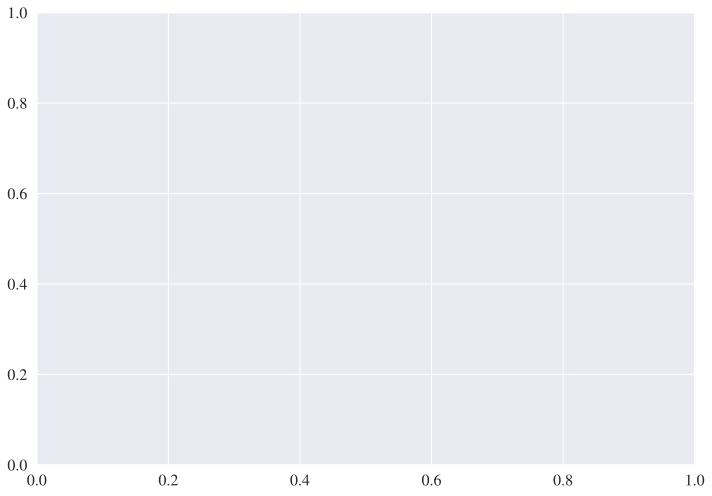

In [46]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
sns.kdeplot(tr, 
            ax=ax,
            label="Tick", 
            bw=0.25,
            color='darkblue')
sns.kdeplot(dr,
            ax=ax,
            label="USD Volume",
            bw=0.55,linewidth=2.25,
            color='blue', linestyle =':')

sns.kdeplot(vr,
            ax=ax,
            label="Volume",
            bw=0.55,linewidth=1.25,
            color='red', linestyle ='--')


plt.xlabel('Returns', fontsize=9)
plt.ylabel('Density', fontsize=9)
plt.xticks(fontsize = 9, rotation = 45)
plt.yticks(fontsize = 9)
plt.title(str(symbol))
file_name = str(hash_of_file) + '_multiclocks_density_plot.png'
plt.savefig(os.path.join(figures_destination,file_name))
plt.legend()
plt.show()



In [ ]:
# Simple normality tests
from scipy.stats import shapiro, normaltest, jarque_bera
bar_choice = volume_standard.values
stat, p = shapiro(bar_choice)
print('stat = %.3f, p = %.3f\n ' % (stat, p))
if p > 0.05:
    print('prob gaussian')
else:
    print('non gaussian')

stat_nt, p_nt = normaltest(bar_choice)

print('stat = %.3f, p = %.3f\n ' % (stat_nt, p_nt))

stat_jb, p_jb = jarque_bera(bar_choice)

print('stat = %.3f, p = %.3f\n ' % (stat_jb, p_jb))

In [ ]:
return_scaled(dr).shape

In [ ]:
import scipy
from matplotlib.ticker import PercentFormatter

for barIdx in range(0,3):
    vol_estimation = volatilityEstimation(bars[barsKeys[barIdx]])

    garman_klass_vol_10 = vol_estimation.garmanKlass(trading_periods = 10)
    garman_klass_vol_50 = vol_estimation.garmanKlass(trading_periods = 50)
    garman_klass_vol_100 = vol_estimation.garmanKlass(trading_periods = 100)

    g1 =sns.distplot(garman_klass_vol_10, hist=True, kde=True, 
                 bins=int(200/5), color = 'darkblue', 
                 hist_kws={'edgecolor':'red'},
                 kde_kws={'linewidth': 2}, 
                    label="10-trading ticks")
    g2 =sns.distplot(garman_klass_vol_50, hist=True, kde=True, 
                 bins=int(200/5), color = 'green', 
                 hist_kws={'edgecolor':'lightblue'},
                 kde_kws={'linewidth': 2},
                    label="50-trading ticks")
    g3 =sns.distplot(garman_klass_vol_100, hist=True, kde=True, 
                 bins=int(200/5), color = 'red', 
                 hist_kws={'edgecolor':'lightblue'},
                 kde_kws={'linewidth': 2},
                    label="100-trading ticks")
    plt.xlabel('xlabel', fontsize=9)
    plt.ylabel('ylabel', fontsize=9)
    plt.xticks(fontsize = 9, rotation = 45)
    plt.yticks(fontsize = 9)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(10))
    plt.legend(fontsize=7)
    _=plt.xlabel(str(barsKeys[barIdx])+' Garman Klass Volatility') #y label
    file_name = str(symbol)+str(barsKeys[barIdx])+'_GK-Klass Histogram.png'
    plt.savefig(os.path.join(figures_destination,file_name))
    plt.show()

In [ ]:
print(barsKeys[barIdx])
for barIdx in range(0,3):
    vol_estimation = volatilityEstimation(bars[barsKeys[barIdx]])
    arrival_rates = vol_estimation.arrival_rates()

    g1 =sns.distplot(arrival_rates, hist=True, kde=True, 
                 bins=int(200/5), color = 'darkblue', 
                 hist_kws={'edgecolor':'red'},
                 kde_kws={'linewidth': 2}, 
                    label="arrival-rates")
    # g2 =sns.distplot(garman_klass_vol_50, hist=True, kde=True, 
    #              bins=int(200/5), color = 'green', 
    #              hist_kws={'edgecolor':'lightblue'},
    #              kde_kws={'linewidth': 2},
    #                 label="50-trading ticks")
    # plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    plt.xlabel('xlabel', fontsize=9)
    plt.ylabel('ylabel', fontsize=9)
    plt.xticks(fontsize = 9, rotation = 45)
    plt.yticks(fontsize = 9)
    #plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    plt.legend(fontsize=7)
    _=plt.xlabel('Arrival rates for '+ str(barsKeys[barIdx])) #y label
  
#     file_name = testSymbol+'_'+str(hash_of_file) + str(barsKeys[barIdx]) +'arrival-rates.png'
#     plt.savefig(os.path.join(figures_destination,file_name))
#     plt.show()

In [ ]:


# print(barsKeys[barIdx])
# for barIdx in range(0,3):
#     vol_estimation = volatilityEstimation(bars[barsKeys[barIdx]])
#     relative_jump_measure_20 = vol_estimation.relative_jump_measure(200)
#     print(pd.DataFrame(relative_jump_measure_20).quantile([.1, .2, .75]).style.format("{:.2%}"))

# #     g1 =sns.distplot(relative_jump_measure_10, hist=True, kde=True, 
# #                  bins=int(200/5), color = 'darkblue', 
# #                  hist_kws={'edgecolor':'red'},
# #                  kde_kws={'linewidth': 2}, 
# #                     label="10-trading-ticks")
    
#     g2 =sns.distplot(relative_jump_measure_20, hist=True, kde=True, 
#                  bins=int(200/5), color = 'green', 
#                  hist_kws={'edgecolor':'lightblue'},
#                  kde_kws={'linewidth': 2},
#                     label="200-trading ticks")
    
#     # plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
#     plt.legend()
#     _=plt.xlabel('Relative jump metric for '+ str(barsKeys[barIdx])) #y label

#     file_name = testSymbol+'_'+str(hash_of_file) + str(barsKeys[barIdx]) +'relative_jump_metric.png'
    
#     plt.savefig(os.path.join(figures_destination,file_name))
#     plt.show()